In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import wandb

#### Inspired by:

https://github.com/pytorch/vision/blob/9e474c3c46c0871838c021093c67a9c7eb1863ea/torchvision/models/video/resnet.py \
https://github.com/leftthomas/R2Plus1D-C3D

### Note:
- We reduced the layer depth as compared to the original model provided in the paper from 2 Conv2Plus1D blocks per layer to 1.
- We removed the Bottleneck Residual Block as we believe it's not needed for low-depth models (like this one).
- We initialised the Conv3D models explicitly for greyscale (channel = 1).

In [36]:
class R2Plus1dStem(nn.Sequential):
    """Stem for R(2+1)D, uses separated 3D convolution for grayscale input."""
    def __init__(self):
        super().__init__(
            nn.Conv3d(1, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False),
            nn.BatchNorm3d(45),
            nn.ReLU(inplace=True),
            nn.Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True)
        )

class Conv2Plus1D(nn.Sequential):
    """(2+1)D Convolution block."""
    def __init__(self, in_planes, out_planes, midplanes, stride=1, padding=1):
        super().__init__(
            nn.Conv3d(in_planes, midplanes, kernel_size=(1, 3, 3), stride=(1, stride, stride), padding=(0, padding, padding), bias=False),
            nn.BatchNorm3d(midplanes),
            nn.ReLU(inplace=True),
            nn.Conv3d(midplanes, out_planes, kernel_size=(3, 1, 1), stride=(stride, 1, 1), padding=(padding, 0, 0), bias=False),
            nn.BatchNorm3d(out_planes)
        )

    @staticmethod
    def get_downsample_stride(stride):
        return (stride, stride, stride)

class BasicBlock(nn.Module):
    """Basic ResNet Block with (2+1)D convolutions."""
    expansion = 1

    def __init__(self, inplanes, planes, conv2Plus1_block, stride=1, downsample=None):
        super().__init__()

        # formula from paper to keep the total number of parameters the same as 3D Conv
        midplanes = (inplanes * planes * 27) // (inplanes * 9 + 9 * planes)
        
        self.conv1 = conv2Plus1_block(inplanes, planes, midplanes, stride)
        self.conv2 = conv2Plus1_block(planes, planes, midplanes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        return self.relu(out + residual)

class R2Plus1D(nn.Module):
    """ResNet-style R(2+1)D model."""
    def __init__(self, blocks_per_layer, num_classes=6):
        super().__init__()
        self.inplanes = 64
        block = BasicBlock
        self.stem = R2Plus1dStem()
        self.layer1 = self._make_layer(block, Conv2Plus1D, 64, blocks_per_layer)
        self.layer2 = self._make_layer(block, Conv2Plus1D, 128, blocks_per_layer, stride=2)
        self.layer3 = self._make_layer(block, Conv2Plus1D, 256, blocks_per_layer, stride=2)
        self.layer4 = self._make_layer(block, Conv2Plus1D, 512, blocks_per_layer, stride=2)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)
        self._initialize_weights()

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        return self.fc(x.flatten(1))

    def _make_layer(self, block, conv_block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(self.inplanes, planes * block.expansion, kernel_size=1, stride=conv_block.get_downsample_stride(stride), bias=False),
                nn.BatchNorm3d(planes * block.expansion)
            )
        layers = [block(self.inplanes, planes, conv_block, stride, downsample)]
        self.inplanes = planes * block.expansion
        layers += [block(self.inplanes, planes, conv_block) for _ in range(1, blocks)]
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [3]:
def train_nn(model, train_loader, criterion, optimizer, device):
    """Train  model for one epoch"""
    model.train()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    for inputs, labels in train_loader:

        # correct input format for Conv3D
        inputs = inputs.permute(0, 2, 1, 3, 4)
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute accuracy
        _, predicted_labels = torch.max(outputs, dim=1)
        correct_labels += (predicted_labels == labels).sum().item()
        total_labels += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def evaluate_nn(model, eval_loader, criterion, device):
    """Evaluate the model after each epoch."""
    model.eval()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    with torch.no_grad():
        for inputs, labels in eval_loader:
            
            # correct input format for Conv3D
            inputs = inputs.permute(0, 2, 1, 3, 4)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Compute accuracy
            _, predicted_labels = torch.max(outputs, dim=1)
            correct_labels += (predicted_labels == labels).sum().item()
            total_labels += labels.size(0)

    avg_loss = running_loss / len(eval_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def run_training(model, train_loader, eval_loader, criterion, device, num_epochs, learning_rate=0.001, step_size=5, gamma=0.5,
                 project='lstm_training', name='test_run'):
    """Train and evaluate the model for a given number of epochs with W&B logging"""

    # Initialize W&B logging
    wandb.init(project=project, name=name, config={
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "step_size": step_size,
        "gamma": gamma,
        "optimizer": "Adam",
    },
    )
    config = wandb.config

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Optimizer
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)  # Learning rate scheduler
    
    train_losses = []
    eval_losses = []
    train_accuracies = []
    eval_accuracies = []
    learning_rates = []

    for epoch in tqdm(range(num_epochs)):
        # Train for one epoch
        train_loss, train_accuracy = train_nn(model, train_loader, criterion, optimizer, device)
        # Evaluate after each epoch
        eval_loss, eval_accuracy = evaluate_nn(model, eval_loader, criterion, device)

        current_lr = scheduler.get_last_lr()[0]


        train_losses.append(train_loss)
        eval_losses.append(eval_loss)
        train_accuracies.append(train_accuracy)
        eval_accuracies.append(eval_accuracy)
        learning_rates.append(current_lr)

        # Log metrics to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "eval_loss": eval_loss,
            "eval_accuracy": eval_accuracy,
            "learning_rate": current_lr
        })

        # Print stats after each epoch
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")
        
        # Step the LR scheduler
        scheduler.step()

    # End W&B run
    wandb.finish()

    return model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates

In [4]:
def plot_confusion_matrix(y_true, y_pred, label_names, model_name):
    """
    Plots confusion matrix for a given model.

    Args:
        y_true (numpy.ndarray): True labels.
        y_pred (numpy.ndarray): Predicted labels.
        label_names (list): List of class names.
        model_name (str): The name of the model to display in the plot title.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names, linewidths=1)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [5]:
# Function to evaluate model and compute predictions
def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.permute(0, 2, 1, 3, 4)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Used: {device}")

Device Used: cuda


In [7]:
class KTHProcessedDataset(Dataset):
    def __init__(self, root_dir, sequence_length=15, transform=None):
        """
        root_dir: path of the parent directory that contains processed frames/images.
        sequence_length: the number of frames in each subsequence.
        transforms: augmentations applied to the frames (can be none or more).
        """
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.transform = transform
        self.data = []
        self.class_mapping = {}

        # Parse through categories
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            category_path = os.path.join(root_dir, category)
            # if not os.path.isdir(category_path):
            #     continue
            self.class_mapping[label] = category
            for subfolder in os.listdir(category_path):
                subfolder_path = os.path.join(category_path, subfolder)
                if os.path.isdir(subfolder_path): # check (folder also contain some json)
                    frames = sorted(os.listdir(subfolder_path))

                    # Create subsequences from frames
                    for start_idx in range(0, len(frames) - sequence_length + 1, sequence_length):  # (0, 450-15+1, 15)
                        subsequence_frames = frames[start_idx:start_idx + sequence_length]          # (0, 0+15), then (15, 30) and so on.
                        if len(subsequence_frames) == sequence_length:
                            self.data.append((subfolder_path, subsequence_frames, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subfolder_path, frames, label = self.data[idx]

        sequence = []
        for frame_file in frames:
            frame_path = os.path.join(subfolder_path, frame_file)
            try:
                img = Image.open(frame_path).convert("L")
                if self.transform:
                    img = self.transform(img)

                # different from 2D models as we're not flattening 3D to 2D
                sequence.append(img)

            except Exception as e:
                # Found some corrupted image in the folders
                print(f"Skipping image {frame_path} due to error: {e}")
                return self.__getitem__((idx + 1) % len(self))

        # Stack frames into tensor
        sequence = torch.stack(sequence, dim=0)
        return sequence, label


In [8]:
# Define augmentations
transform = transforms.Compose([
    
    # RandomHorizontalFlip(p=0.5),
    # RandomRotation(degrees=15),
    transforms.RandomCrop(size=(64, 64), pad_if_needed=True),

    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.3),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    
    transforms.ToTensor(),                             
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [9]:
# Paths and hyperparameters
root_dir = '/home/nfs/inf6/data/datasets/kth_actions/processed'
sequence_length = 45
batch_size = 16
train_ratio = 0.8  # 80% for train 20% for val

In [10]:
# Load the whole dataset
dataset = KTHProcessedDataset(root_dir=root_dir, sequence_length=sequence_length, transform=transform)

# Calculate train and validation sizes
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split dataset into train and val
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders for train and val sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Dataset size: {dataset_size}")
print(f"Train set size: {train_size}")
print(f"Validation set size: {val_size}")

Dataset size: 6150
Train set size: 4920
Validation set size: 1230


In [11]:
print("Dataset Classes:")
for class_id, class_name in dataset.class_mapping.items():
    print(f"Class ID: {class_id}, Class Name: {class_name}")

Dataset Classes:
Class ID: 0, Class Name: boxing
Class ID: 1, Class Name: handclapping
Class ID: 2, Class Name: handwaving
Class ID: 3, Class Name: jogging
Class ID: 4, Class Name: running
Class ID: 5, Class Name: walking


In [12]:
# reverse mapping of the dataclasses
reverse_mapping = {val:key for key,val in dataset.class_mapping.items()}
reverse_mapping

{'boxing': 0,
 'handclapping': 1,
 'handwaving': 2,
 'jogging': 3,
 'running': 4,
 'walking': 5}

In [37]:
num_classes = len(os.listdir("/home/nfs/inf6/data/datasets/kth_actions/processed"))  # Number of output classes

model = R2Plus1D(blocks_per_layer=1, num_classes=num_classes).to(device)
model

R2Plus1D(
  (stem): R2Plus1dStem(
    (0): Conv3d(1, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2Plus1D(
        (0): Conv3d(64, 96, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
        (1): BatchNorm3d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(96, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2): Conv2Plus1D(
        (0

In [20]:
# Hyperparameters for training
num_epochs = 30
learning_rate = 0.0005  # Initial learning rate
step_size = 6          # To be used in LR Scheduler
gamma = 0.5            # To be used in LR Schedussler
name = f"R(2+1)D_ep_{num_epochs}_lr_5e-4"
project = 'assignment-4'

#criterion
criterion = nn.CrossEntropyLoss()

In [16]:
model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates = run_training(
    model, 
    train_loader, val_loader, 
    criterion,
    device,
    num_epochs=num_epochs, 
    learning_rate=learning_rate, 
    step_size=step_size, 
    gamma=gamma,
    name=name, project=project
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ahmadjaved97. Use `wandb login --relogin` to force relogin


  3%|██▊                                                                                | 1/30 [01:44<50:27, 104.39s/it]

Epoch 1/30
Train Loss: 1.0188, Train Accuracy: 0.5201
Eval Loss: 0.9076, Eval Accuracy: 0.5634
Learning Rate: 0.000500


  7%|█████▌                                                                             | 2/30 [03:30<49:16, 105.59s/it]

Epoch 2/30
Train Loss: 0.6788, Train Accuracy: 0.6833
Eval Loss: 0.5733, Eval Accuracy: 0.7488
Learning Rate: 0.000500


 10%|████████▎                                                                          | 3/30 [05:17<47:39, 105.90s/it]

Epoch 3/30
Train Loss: 0.5459, Train Accuracy: 0.7539
Eval Loss: 1.6173, Eval Accuracy: 0.6179
Learning Rate: 0.000500


 13%|███████████                                                                        | 4/30 [07:00<45:25, 104.84s/it]

Epoch 4/30
Train Loss: 0.4709, Train Accuracy: 0.7886
Eval Loss: 0.3764, Eval Accuracy: 0.8301
Learning Rate: 0.000500


 17%|█████████████▊                                                                     | 5/30 [08:44<43:37, 104.68s/it]

Epoch 5/30
Train Loss: 0.4230, Train Accuracy: 0.8093
Eval Loss: 0.4214, Eval Accuracy: 0.8041
Learning Rate: 0.000500


 20%|████████████████▌                                                                  | 6/30 [10:29<41:56, 104.87s/it]

Epoch 6/30
Train Loss: 0.3628, Train Accuracy: 0.8390
Eval Loss: 0.3255, Eval Accuracy: 0.8455
Learning Rate: 0.000500


 23%|███████████████████▎                                                               | 7/30 [12:16<40:24, 105.40s/it]

Epoch 7/30
Train Loss: 0.2983, Train Accuracy: 0.8634
Eval Loss: 0.2618, Eval Accuracy: 0.8813
Learning Rate: 0.000250


 27%|██████████████████████▏                                                            | 8/30 [14:00<38:31, 105.07s/it]

Epoch 8/30
Train Loss: 0.2586, Train Accuracy: 0.8813
Eval Loss: 0.2539, Eval Accuracy: 0.8837
Learning Rate: 0.000250


 30%|████████████████████████▉                                                          | 9/30 [15:45<36:46, 105.07s/it]

Epoch 9/30
Train Loss: 0.2440, Train Accuracy: 0.8972
Eval Loss: 0.2869, Eval Accuracy: 0.8691
Learning Rate: 0.000250


 33%|███████████████████████████▎                                                      | 10/30 [17:30<35:00, 105.05s/it]

Epoch 10/30
Train Loss: 0.2164, Train Accuracy: 0.9104
Eval Loss: 0.2712, Eval Accuracy: 0.8772
Learning Rate: 0.000250


 37%|██████████████████████████████                                                    | 11/30 [19:16<33:21, 105.35s/it]

Epoch 11/30
Train Loss: 0.1938, Train Accuracy: 0.9236
Eval Loss: 0.2204, Eval Accuracy: 0.9098
Learning Rate: 0.000250


 40%|████████████████████████████████▊                                                 | 12/30 [21:00<31:27, 104.87s/it]

Epoch 12/30
Train Loss: 0.1555, Train Accuracy: 0.9427
Eval Loss: 0.1890, Eval Accuracy: 0.9203
Learning Rate: 0.000250


 43%|███████████████████████████████████▌                                              | 13/30 [22:48<30:00, 105.88s/it]

Epoch 13/30
Train Loss: 0.0960, Train Accuracy: 0.9661
Eval Loss: 0.1770, Eval Accuracy: 0.9317
Learning Rate: 0.000125


 47%|██████████████████████████████████████▎                                           | 14/30 [24:35<28:18, 106.14s/it]

Epoch 14/30
Train Loss: 0.0787, Train Accuracy: 0.9711
Eval Loss: 0.1526, Eval Accuracy: 0.9398
Learning Rate: 0.000125


 50%|█████████████████████████████████████████                                         | 15/30 [26:18<26:16, 105.10s/it]

Epoch 15/30
Train Loss: 0.0678, Train Accuracy: 0.9766
Eval Loss: 0.1659, Eval Accuracy: 0.9374
Learning Rate: 0.000125


 53%|███████████████████████████████████████████▋                                      | 16/30 [28:03<24:30, 105.02s/it]

Epoch 16/30
Train Loss: 0.0526, Train Accuracy: 0.9813
Eval Loss: 0.1804, Eval Accuracy: 0.9301
Learning Rate: 0.000125


 57%|██████████████████████████████████████████████▍                                   | 17/30 [29:54<23:08, 106.78s/it]

Epoch 17/30
Train Loss: 0.0423, Train Accuracy: 0.9852
Eval Loss: 0.1809, Eval Accuracy: 0.9382
Learning Rate: 0.000125


 60%|█████████████████████████████████████████████████▏                                | 18/30 [31:40<21:20, 106.72s/it]

Epoch 18/30
Train Loss: 0.0497, Train Accuracy: 0.9827
Eval Loss: 0.1626, Eval Accuracy: 0.9423
Learning Rate: 0.000125


 63%|███████████████████████████████████████████████████▉                              | 19/30 [33:24<19:24, 105.89s/it]

Epoch 19/30
Train Loss: 0.0278, Train Accuracy: 0.9937
Eval Loss: 0.1661, Eval Accuracy: 0.9520
Learning Rate: 0.000063


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [35:11<17:41, 106.15s/it]

Epoch 20/30
Train Loss: 0.0164, Train Accuracy: 0.9963
Eval Loss: 0.1872, Eval Accuracy: 0.9366
Learning Rate: 0.000063


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [36:56<15:51, 105.77s/it]

Epoch 21/30
Train Loss: 0.0139, Train Accuracy: 0.9972
Eval Loss: 0.1820, Eval Accuracy: 0.9358
Learning Rate: 0.000063


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [38:42<14:07, 105.97s/it]

Epoch 22/30
Train Loss: 0.0146, Train Accuracy: 0.9959
Eval Loss: 0.1753, Eval Accuracy: 0.9488
Learning Rate: 0.000063


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [40:27<12:19, 105.62s/it]

Epoch 23/30
Train Loss: 0.0120, Train Accuracy: 0.9970
Eval Loss: 0.2050, Eval Accuracy: 0.9407
Learning Rate: 0.000063


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [42:11<10:30, 105.06s/it]

Epoch 24/30
Train Loss: 0.0095, Train Accuracy: 0.9982
Eval Loss: 0.1778, Eval Accuracy: 0.9390
Learning Rate: 0.000063


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [43:55<08:44, 104.96s/it]

Epoch 25/30
Train Loss: 0.0077, Train Accuracy: 0.9990
Eval Loss: 0.1772, Eval Accuracy: 0.9439
Learning Rate: 0.000031


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [45:42<07:01, 105.46s/it]

Epoch 26/30
Train Loss: 0.0051, Train Accuracy: 0.9994
Eval Loss: 0.1852, Eval Accuracy: 0.9431
Learning Rate: 0.000031


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [47:27<05:15, 105.29s/it]

Epoch 27/30
Train Loss: 0.0035, Train Accuracy: 1.0000
Eval Loss: 0.1952, Eval Accuracy: 0.9415
Learning Rate: 0.000031


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [49:11<03:29, 104.91s/it]

Epoch 28/30
Train Loss: 0.0032, Train Accuracy: 1.0000
Eval Loss: 0.1914, Eval Accuracy: 0.9480
Learning Rate: 0.000031


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [51:00<01:46, 106.09s/it]

Epoch 29/30
Train Loss: 0.0051, Train Accuracy: 0.9990
Eval Loss: 0.2075, Eval Accuracy: 0.9358
Learning Rate: 0.000031


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [52:47<00:00, 105.57s/it]

Epoch 30/30
Train Loss: 0.0041, Train Accuracy: 0.9994
Eval Loss: 0.2019, Eval Accuracy: 0.9439
Learning Rate: 0.000031


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
eval_accuracy,▁▄▂▆▅▆▇▇▇▇▇▇██████████████████
eval_loss,▅▃█▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,██████▄▄▄▄▄▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇██████████████████
train_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,0.9439
eval_loss,0.20194
learning_rate,3e-05
train_accuracy,0.99939


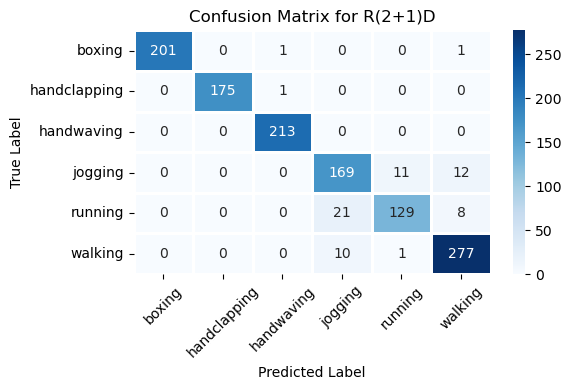

In [17]:
y_true, y_pred = evaluate_model(model, val_loader)

# Class label names
label_names = ['boxing','handclapping', 'handwaving', 'jogging', 'running', 'walking']

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, label_names, model_name="R(2+1)D")

In [31]:
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

      boxing       1.00      0.99      1.00       203
handclapping       1.00      0.99      1.00       176
  handwaving       0.99      1.00      1.00       213
     jogging       0.84      0.88      0.86       192
     running       0.91      0.82      0.86       158
     walking       0.93      0.96      0.95       288

    accuracy                           0.95      1230
   macro avg       0.95      0.94      0.94      1230
weighted avg       0.95      0.95      0.95      1230



## Observations

- Training time: 53 minutes (Note that this is a low-depth model as compared to the original R2Plus1_18 as proposed in the paper originally, almost half the depth)
- The model starts overfitting on train data around epoch 15. This migth be a result of either inadequate hyperparameters or not enough data for the given model depth. A hyperparameter search can be performed using packages like optuna but due to large training times this was not performed.
- Perfect classification for handwaving and almost perfect for boxing and handclapping.
- Worst classification for jogging, which was expected as movements in jogging at low pace resembel walking, and jogging at high pace resembel running
- Overall better performance than all other models in all metrics